In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mapmanagercore import MapAnnotations, MultiImageLoader
import matplotlib.pyplot as plt
# Create an image loader
loader = MultiImageLoader(
    lineSegments="../data/rr30a_s0u/line_segments.csv",
    points="../data/rr30a_s0u/points.csv")

# add image channels to the loader
loader.read("../data/rr30a_s0u/t0/rr30a_s0_ch1.tif", channel=0)
loader.read("../data/rr30a_s0u/t0/rr30a_s0_ch2.tif", channel=1)
loader.readMetadata("../data/rr30a_s0u/metadata.json")

# loader.read("../data/rr30a_s0u/t0/rr30a_s0_ch1.tif", channel=0, time=1)
# loader.read("../data/rr30a_s0u/t0/rr30a_s0_ch2.tif", channel=1, time=1)
# loader.readMetadata("./data/rr30a_s0u/metadata.json")


# Create the annotation map
map = MapAnnotations(loader)
map.points[:]
map.segments[:]

# save the annotation map
map.save("../data/rr30a_s0u.mmap")
map.close()


/Users/work/Desktop/source/WebMapManager/src/MapManagerCore/mapmanagercore/lazy_geo_pandas/schema.py:107: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[:, key] = df.loc[:, key].fillna(defaults[key])


In [8]:
from mapmanagercore import MapAnnotations, MMapLoader
import matplotlib.pyplot as plt
map = MapAnnotations(MMapLoader("../data/rr30a_s0u.mmap"))

In [9]:
map2 = map.getTimePoint(0)

In [10]:
import geopandas as gpd

/Users/work/miniconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:2469: FutureWarning: The `drop` keyword argument is deprecated and in future the only supported behaviour will match drop=False. To silence this warning and adopt the future behaviour, stop providing `drop` as a keyword to `set_geometry`. To replicate the `drop=True` behaviour you should update your code to
`geo_col_name = gdf.active_geometry_name; gdf.set_geometry(new_geo_col).drop(columns=geo_col_name).rename_geometry(geo_col_name)`.
  return gf.set_geometry(col, drop=drop, inplace=False, crs=crs)


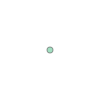

In [11]:
import numpy as np
from shapely.geometry import LineString, Point
from mapmanagercore.layers.utils import roundPoint
segmentID = 0
pointId = 1
self = map2
point = self.points[pointId, "point"]
point = Point(point.x, point.y, self.points[pointId, "z"])
brightestPathDistance = 300
channel = 1
zSpread = 0

segment: LineString = self.segments[segmentID, "segment"]
minProjection = segment.project(point)
segmentLength = int(segment.length)
minProjection = int(minProjection)
range_ = range(
    max(minProjection-brightestPathDistance, 0),
    min(minProjection +
        brightestPathDistance + 1, segmentLength))

targets = gpd.GeoSeries([LineString([point, roundPoint(segment.interpolate(distance), 1)]) for distance in range_])

pixcels = self.getShapePixels(
    targets, channel=channel, zSpread=zSpread)
brightest = (pixcels.apply(np.median) / targets.length).idxmax()
Point(targets[brightest].coords[1])

(270.0, 200.0)

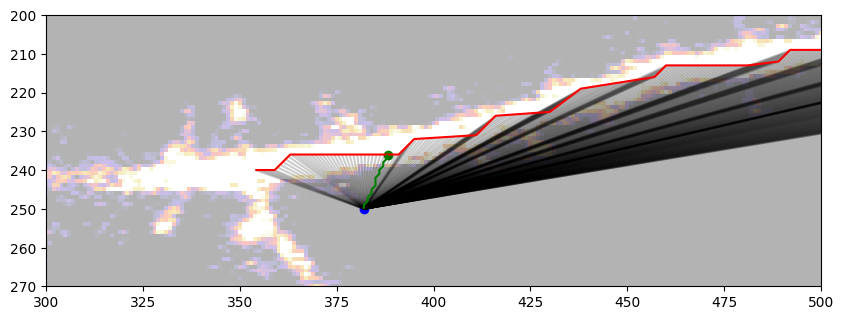

In [12]:
from mapmanagercore.utils import shapeIndexes
import shapely


fig, ax = plt.subplots(figsize=(10, 10))

gpd.GeoSeries(targets).plot(color=(0,0,0,0.2), ax=ax);
self.segments[[segmentID], "segment"].plot(ax=ax, color="red");
self.points[[pointId], "point"].plot(ax=ax, color="blue");
gpd.GeoSeries([Point(targets[brightest].coords[1])]).plot(ax=ax, color="green");
xs, ys = shapeIndexes(targets[brightest])
gpd.GeoSeries([shapely.geometry.LineString(list(zip(xs, ys)))]).plot(ax=ax, color="green");
slices = map.getPixels(time=0, channel=channel, zRange=(31, 31))
slices.plot(ax=ax, vmin=300, vmax=1500, alpha=0.3, cmap='CMRmap')
ax.set_xlim(300, 500)
ax.set_ylim(270, 200)

6912

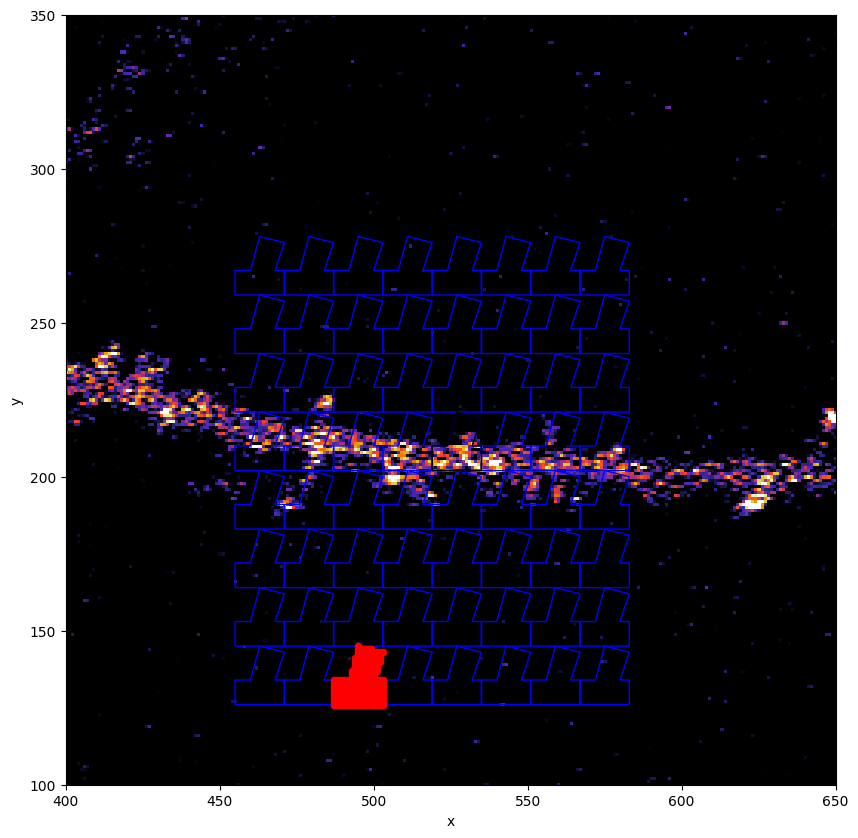

In [14]:
import numpy as np
import shapely.affinity
from mapmanagercore.utils import shapeGrid, shapeIndexes
import geopandas as gp
import shapely
import pandas as pd
fig, ax = plt.subplots(figsize=(10, 10))
pointID = 5
roi = map2.points[pointID, "roi"]
grid = shapeGrid(roi, points=8, overlap=0)
candidates = grid.apply(lambda x: shapely.affinity.translate(roi, x["x"], x["y"]), axis=1)
pixcels=map2.getShapePixels(candidates, channel=0, zSpread=0, z=map2.points[0, "z"])
dimmest = pixcels.apply(np.sum).idxmin()
# grid.plot(ax=ax, x="x", y="y", kind="scatter")
gp.GeoSeries(candidates).plot(ax=ax, facecolor="none", edgecolor="blue");
gp.GeoSeries([candidates[dimmest]]).plot(ax=ax, facecolor="none", edgecolor="red");
# grid.iloc[[pixcels.apply(np.sum).idxmin()]].plot(ax=ax, x="x", y="y", color="red", kind="scatter");
gp.GeoSeries([roi]).plot(ax=ax, facecolor="none", edgecolor="black");
slices = map.getPixels(time=0, channel=0, zRange=(map2.points[pointID, "z"], map2.points[pointID, "z"]))
xs, ys = shapeIndexes(candidates[dimmest])
slices.plot(ax=ax, vmin=300, vmax=1500, alpha=1, cmap='CMRmap')
# pd.DataFrame({"x": xs, "y": ys}).plot(ax=ax, x="x", y="y", kind="scatter", color="red")
ax.set_xlim(400, 650)
ax.set_ylim(100, 350)
slices._image[xs, ys].sum()